## Noisy RGB pixels, Conv + UNet + Residual + Conv + Residual, 1/8 U-Net bottleneck, L1 + L2 + Perceptual + Adversarial Loss

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    return {
        'w': w,
        'h': h,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


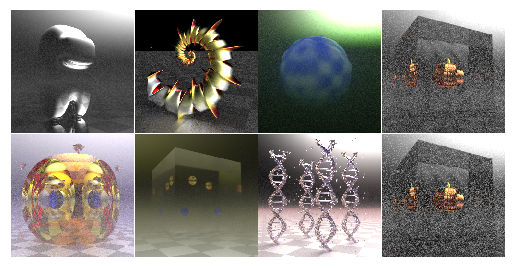

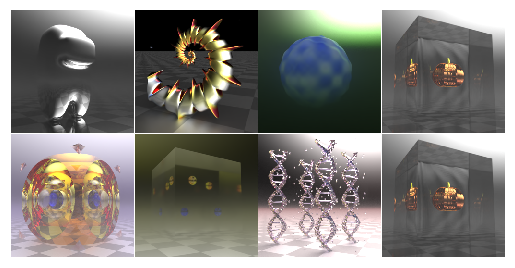

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.convi = conv3(3, n0)
        self.econv0a = conv3(n0, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.econv3b = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo = conv3(n0, 3)

    def forward(self, input):
        ci = self.convi(input)
        e0 = self.econv0b(relu(self.econv0a(relu(ci)))) # 1
        e1 = self.econv1b(relu(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(relu(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(relu(self.econv3a(pool(e2)))) # 1/8
        d2 = relu(self.dconv2a(relu(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.convo(ci+do) + input


model = Model().to(device)
print(model)

Model(
  (convi): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0a): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3a): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(1, 1)

In [5]:
"""Image Denoising Using A Generative Adversarial Network,
    Code modified from implementation by Jeffrey Ming Han Li"""

class Discriminator(torch.nn.Module):
    def __init__(self,K2):
        super(Discriminator, self).__init__()

        # Basic convolutional block
        def conv_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(0.01, inplace=True)
            )
        def last_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Sigmoid()
            )

        self.model = torch.nn.Sequential(
            conv_block(3,K2, kernel_size=4, stride=2),
            conv_block(K2,3*K2//2, kernel_size=4, stride=2),
            conv_block(3*K2//2,K2*2, kernel_size=4, stride=2),
            conv_block(K2*2,K2*3, kernel_size=4, stride=2),
            conv_block(K2*3,K2*4, kernel_size=4, stride=2),
            conv_block(K2*4,K2*4, kernel_size=3, stride=1),
            last_block(K2*4,1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        y = self.model(x)
        # print(y.shape)
        return torch.clip(torch.mean(y, axis=(2, 3)), 0.0, 1.0)


class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_s):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a
        self.lambda_p = lambda_p
        self.lambda_f = lambda_f
        self.lambda_s = lambda_s

        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        self.feature_extractor = vgg16.features[:4].to(device)
        print(self.feature_extractor)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        print(self.feature_extractor_2)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False

    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # Adversarial Loss
        if is_discriminator:
            return F.binary_cross_entropy(discriminator_output, target)
        loss_a = -torch.mean(discriminator_output)

        # Pixel Loss (Euclidean Distance, L1+L2 Loss)
        loss_p2 = torch.mean((generated-target)**2) / 0.05
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # Feature Loss (Euclidean Distance, L1+L2 Loss)
        gen_features = self.feature_extractor(generated)
        target_features = self.feature_extractor(target)
        loss_f2 = torch.mean((gen_features-target_features)**2) / 0.05
        loss_f1 = torch.mean(torch.abs(gen_features-target_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        target_features_2 = self.feature_extractor_2(target_features)
        loss_f2_2 = torch.mean((gen_features_2-target_features_2)**2) / 0.05
        loss_f1_2 = torch.mean(torch.abs(gen_features_2-target_features_2))
        loss_f = 0.25*(loss_f1+loss_f2+loss_f1_2+loss_f2_2)

        # Smooth Loss (Total Variation Loss)
        gen_s = (generated[:,:,:-1,:-1] - generated[:,:,1:,1:])**2 + \
                (generated[:,:,:-1,1:] - generated[:,:,1:,:-1])**2
        target_s = (target[:,:,:-1,:-1] - target[:,:,1:,1:])**2 + \
                (target[:,:,:-1,1:] - target[:,:,1:,:-1])**2
        loss_s = F.mse_loss(torch.sqrt(gen_s), torch.sqrt(target_s)) / 0.05

        # Composite Loss
        total_loss = self.lambda_a * loss_a + self.lambda_p * loss_p + \
                        self.lambda_f * loss_f + self.lambda_s * loss_s

        return total_loss


discriminator = Discriminator(16).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)
Sequential(
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
)
64 g 2.133723735809326 d 1.3207573890686035
128 g 1.3756965398788452 d 1.2973217964172363
192 g 1.71613609790802 d 1.282167673110962
256 g 1.3960390090942383 d 1.281158208847046
320 g 0.9627808928489685 d 1.273160696029663
384 g 0.7867329716682434 d 1.2711055278778076
448 g 0.9674816131591797 d 1.2655274868011475
512 g 0.8281196355819702 d 1.2736051082611084
576 g 0.8855711221694946 d 1.2560522556304932
640 g 0.506425142288208 d 1.259277582168579
704 g 0.6120702028274536 d 1.263938665390

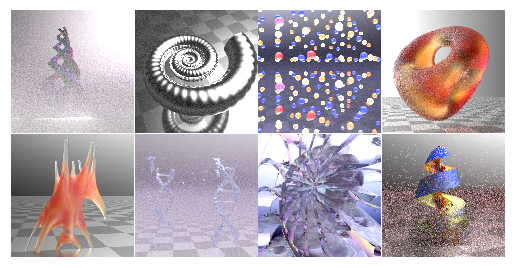

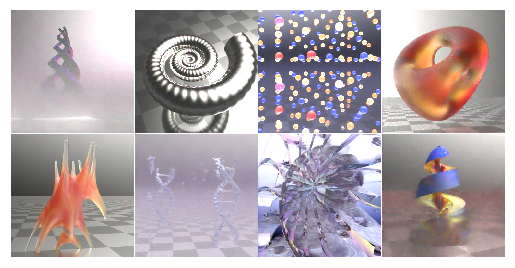

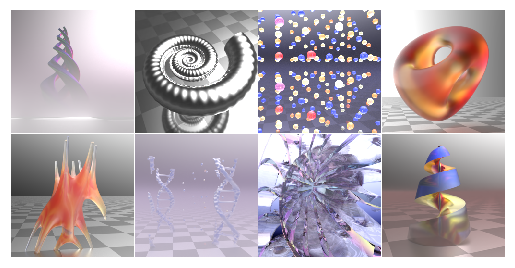

2112 g 0.24996742606163025 d 1.2137229442596436
2176 g 0.3295254707336426 d 1.2032922506332397
2240 g 0.4924287796020508 d 1.17707359790802
2304 g 0.4459649622440338 d 1.1822538375854492
2368 g 0.2257760763168335 d 1.1798290014266968
2432 g 0.532497227191925 d 1.165589690208435
2496 g 0.28333497047424316 d 1.173515796661377
2560 g 0.48385804891586304 d 1.1623306274414062
2624 g 0.19402146339416504 d 1.176142930984497
2688 g 0.6777909994125366 d 1.156142234802246
2752 g 0.39378592371940613 d 1.1673321723937988
2816 g 0.8624512553215027 d 1.1586514711380005
2880 g 0.43022170662879944 d 1.1423423290252686
2944 g 0.28994420170783997 d 1.1452205181121826
3008 g 0.4936778247356415 d 1.1491825580596924
3072 g 0.6200852394104004 d 1.1422902345657349
3136 g 0.3401341438293457 d 1.1414015293121338
3200 g 0.6432704925537109 d 1.1853286027908325
3264 g 0.5029709339141846 d 1.1422585248947144
3328 g 0.564204216003418 d 1.1395699977874756
3392 g 0.15142622590065002 d 1.1221938133239746
3456 g 0.4852

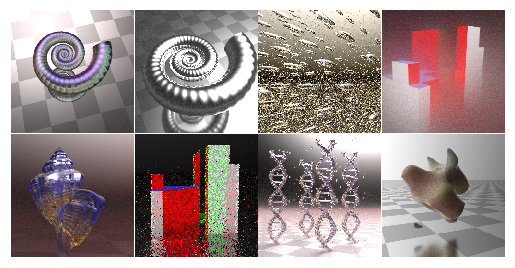

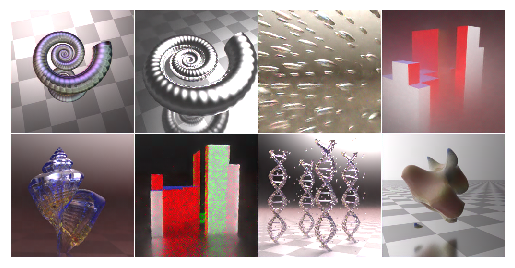

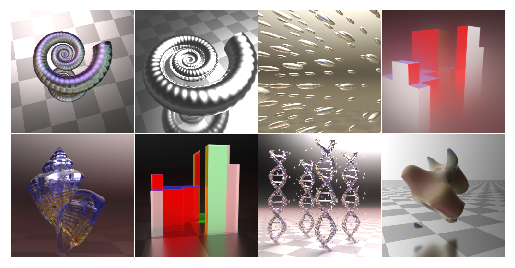

4160 g 0.39718735218048096 d 1.0736050605773926
4224 g 0.45876526832580566 d 1.0825135707855225
4288 g 0.40243667364120483 d 1.0959522724151611
4352 g 0.30706387758255005 d 1.0927667617797852
4416 g 0.18345865607261658 d 1.0701091289520264
4480 g 0.30357789993286133 d 1.089907169342041
4544 g 0.2646520435810089 d 1.0650752782821655
4608 g 0.6024775505065918 d 1.0517958402633667
4672 g 0.5181551575660706 d 1.0539755821228027
4736 g 0.13782332837581635 d 1.04169762134552
4800 g 0.38510435819625854 d 1.039973497390747
4864 g 0.19074682891368866 d 1.0531189441680908
4928 g 0.2689134478569031 d 1.034121036529541
4992 g 0.46690478920936584 d 1.0457851886749268
5056 g 0.33997514843940735 d 1.0301992893218994
5120 g 0.3604676425457001 d 1.0248512029647827
5184 g 0.44857028126716614 d 1.0296120643615723
5248 g 0.3421209454536438 d 1.0228869915008545
5312 g 0.2355337142944336 d 1.0201478004455566
5376 g 0.6520006656646729 d 1.0156583786010742
5440 g 0.38038814067840576 d 1.0122724771499634
5504 

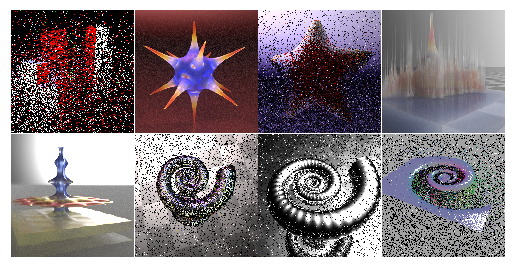

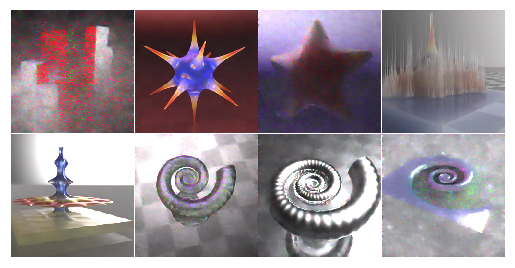

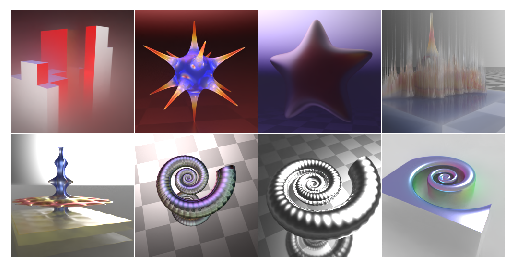

6208 g 0.35223567485809326 d 0.9739192724227905
6272 g 0.3082919120788574 d 1.033591628074646
6336 g 0.226878821849823 d 0.9758055806159973
6400 g 0.34330153465270996 d 0.9906416535377502
6464 g 0.3160891532897949 d 0.9758569598197937
6528 g 0.3477861285209656 d 0.9706287384033203
6592 g 0.2206115424633026 d 0.9648518562316895
6656 g 0.14077332615852356 d 0.9615750908851624
6720 g 0.3596711754798889 d 0.9623933434486389
6784 g 0.6032158732414246 d 0.9522322416305542
6848 g 0.2855740189552307 d 0.947901725769043
6912 g 0.4179956614971161 d 1.0040191411972046
6976 g 0.15485471487045288 d 1.3494364023208618
7040 g 0.5668318271636963 d 0.9717522859573364
7104 g 0.7865114212036133 d 0.9451920986175537
7168 g 0.27730557322502136 d 0.9420486688613892
7232 g 0.3000609576702118 d 0.9415706396102905
Epoch 00049: reducing learning rate of group 0 to 1.0000e-04.
7296 g 0.3543901741504669 d 0.9328039884567261
7360 g 0.5513325333595276 d 0.9385592937469482
7424 g 0.2718273997306824 d 0.9702572226524

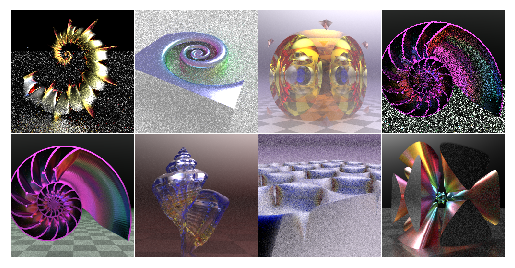

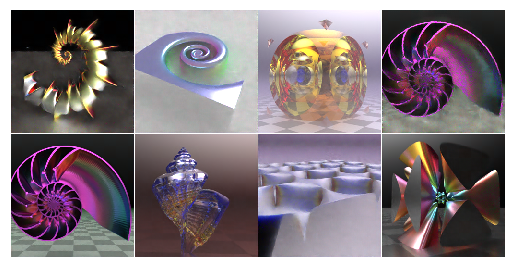

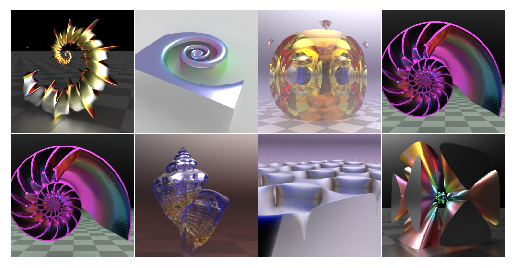

8256 g 0.4311976432800293 d 0.8977875709533691
8320 g 0.6718916893005371 d 0.891776442527771
8384 g 0.41666746139526367 d 0.8938957452774048
8448 g 0.45114755630493164 d 0.8928123712539673
8512 g 0.29005175828933716 d 0.9082908630371094
8576 g 0.2618996500968933 d 0.8891307711601257
Epoch 00070: reducing learning rate of group 0 to 1.0000e-05.
8640 g 0.24233299493789673 d 0.9321467876434326
8704 g 0.34917059540748596 d 0.9100922346115112
8768 g 0.46487337350845337 d 0.8803476095199585
8832 g 0.2782363295555115 d 0.8837343454360962
8896 g 0.2512528598308563 d 0.8697303533554077
8960 g 0.200691357254982 d 0.8884782791137695
9024 g 0.483905553817749 d 0.8723304271697998
9088 g 0.13335181772708893 d 0.8623761534690857
9152 g 0.3175604045391083 d 0.869422435760498
9216 g 0.2235710620880127 d 0.8582825660705566
9280 g 0.2126512974500656 d 0.8569073677062988
9344 g 0.3204113245010376 d 0.8689581155776978
9408 g 0.28835153579711914 d 0.8679051399230957
9472 g 0.24947091937065125 d 0.8903327584

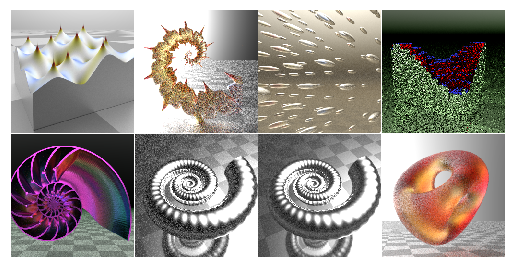

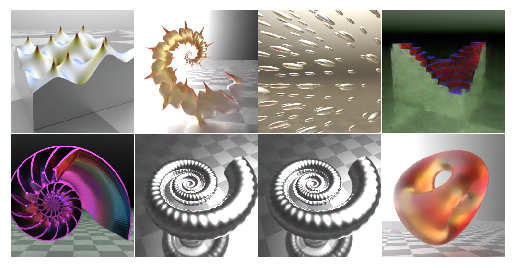

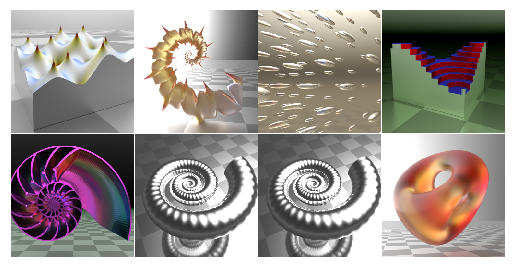

10304 g 0.26618459820747375 d 0.8190668225288391
10368 g 0.53446364402771 d 0.8173999190330505
10432 g 0.26069676876068115 d 0.8665517568588257
10496 g 0.5760781764984131 d 0.8321186304092407
10560 g 0.14949358999729156 d 0.8218493461608887
10624 g 0.11989860236644745 d 0.8505483865737915
10688 g 0.2907755970954895 d 0.8124735951423645
10752 g 0.34144729375839233 d 0.8148560523986816
10816 g 0.18710468709468842 d 0.807199239730835
10880 g 0.36371344327926636 d 0.8011619448661804
10944 g 0.4392572045326233 d 0.7996580600738525
11008 g 0.21885782480239868 d 0.8052951693534851
11072 g 0.32966312766075134 d 0.7990548610687256
11136 g 0.37888720631599426 d 0.797881007194519
11200 g 0.2426910400390625 d 0.7993177771568298
11264 g 0.46119967103004456 d 0.8066457509994507
Epoch 00112: reducing learning rate of group 0 to 1.0000e-07.


In [6]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=20, min_lr=0.0, verbose=True)

optimizer_d = torch.optim.Adam(
    discriminator.parameters(),
    lr = 0.0002
)

# model 0: 0.2 GAN
# model 2: 0.2 GAN, 4.0 no drift loss (without bias correction)
# model 3: 0.2 GAN, 1.0 no drift loss
# model 4: 0.1 GAN, 1.0 no drift loss
lossfun = CombinedLoss(0.1, 1.0, 1.0, 0.0)

discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 16
batch_count = 0
terminate = False
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=batch_size, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        no_drift_loss = 1.0 * torch.mean(torch.log(torch.mean(
            torch.clip(torch.exp(fake_images)-1.0,0.0,1e3)**2.2 - \
            torch.clip(torch.exp(y)-1.0,0.0,1e3)**2.2,
            axis=(2, 3))**2+1.0)) / 0.05
        (g_loss+no_drift_loss).backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 64 == 0:
            print(batch_count, 'g', g_loss.item(), 'd', d_loss.item())
            if batch_count > 4096:
                scheduler.step(g_loss)
            if optimizer.param_groups[0]['lr'] < 1e-6:
                terminate = True
                break
        if batch_count % 2048 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(fake_images.detach())-1)
            plot_imgs(torch.exp(y)-1)
            model_path = "model6.pth"
            torch.save(model, model_path)
    if terminate:
        break

torch.save(model, model_path)
